In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']=""
os.environ['OMP_NUM_THREADS']="4"
os.environ['NUMBA_NUM_THREADS']="4"
os.environ['MKL_NUM_THREADS']="4"

In [2]:
%load_ext autoreload
%autoreload 2 
import pandas as pd; import anndata; import numpy as np; import gzip; import io; import h5py
import collections; import matplotlib.pyplot as plt; import time; import sys; import tqdm.notebook
import pickle; import scipy as sp; import scipy.sparse; import scipy.stats; rng=np.random.default_rng()
import PIL; PIL.Image.MAX_IMAGE_PIXELS = None; import matplotlib
%matplotlib inline
plt.rcParams.update({
    "figure.facecolor":  (1.0, 1.0, 1.0, 1.0),
    "axes.facecolor":    (1.0, 1.0, 1.0, 1.0),
    "savefig.facecolor": (1.0, 1.0, 1.0, 1.0),
    "text.usetex": True,
})
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

In [3]:
def process(fn):
    with h5py.File(fn,'r') as f:
        dct={}
        for x in ['Animal_ID', 'Animal_sex', 'Behavior', 'Bregma', 'Cell_ID', 'Cell_class', 
                  'Centroid_X', 'Centroid_Y', 'Neuron_cluster_ID']:
            dct[x]=f[x][:]
            if dct[x].dtype.kind=='S':
                dct[x]=dct[x].astype("U")
        for x in ['Animal_ID', 'Animal_sex', 'Behavior', 'Bregma', 'Cell_class', 'Neuron_cluster_ID']:
            dct[x]=pd.Categorical(dct[x])
        X=f['expression'][:]
        var=pd.DataFrame(index=f['gene_names'][:].astype('U'))
    ad=anndata.AnnData(X=X,var=var,obs=pd.DataFrame(data=dct),dtype=np.float32) # <-- stored as float16 (!)
    ad.obs['tissue_id']=pd.Categorical(ad.obs.Animal_ID.astype(str).str.cat(ad.obs.Bregma.astype(str),sep='_'))
   
    dct=collections.defaultdict(list)
    for x in ad.obs.tissue_id.cat.categories:
        idx=np.where(ad.obs.tissue_id==x)[0][0]
        for nm in ['Animal_ID','Animal_sex','Behavior','Bregma']:
            dct[nm].append(ad.obs.iloc[idx][nm])
        dct['tissue_id'].append(x)
    df=pd.DataFrame(dct,index=dct['tissue_id'])
    df['split']=np.where(df['Animal_ID'].values>30,'test','train')
    ad.uns['tissueinfo']=df

    return ad

import sklearn.neighbors
basefn='/data/spatial/deepst_synthetic/'

# load

In [8]:
ad=process(basefn+"synth8.hdf5")

/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


# construct edges

In [9]:
radius=30
loc=ad.obs[['Centroid_X','Centroid_Y']].values
rows=[]
cols=[]
for nm in tqdm.notebook.tqdm(ad.obs.tissue_id.cat.categories):
    indicator=ad.obs.tissue_id==nm
    adjacency=sklearn.neighbors.radius_neighbors_graph(loc[indicator],radius).tocoo()
    rows.extend(np.where(indicator)[0][adjacency.row])
    cols.extend(np.where(indicator)[0][adjacency.col])
adjacency=sp.sparse.coo_matrix((np.ones(len(rows)),(rows,cols)),shape=(len(ad),len(ad))).tocsr()

  0%|          | 0/181 [00:00<?, ?it/s]

In [10]:
X1sum=(adjacency@ad.X[:,1]+ad.X[:,1])
X0=ad.X[:,0]

print("MSE",np.mean((np.where(X1sum>1,X1sum,0)-X0)**2))
print("MSE",np.mean((np.where(X1sum>=1,X1sum,0)-X0)**2))
print("MSE",np.mean((np.where(X1sum>.997,X1sum,0)-X0)**2))

MSE 0.0023150182148342466
MSE 0.0030067547361875987
MSE 0.0024559966978635705


In [33]:
floating_issues = np.where(X1sum>1,X1sum,0)
# print(floating_issues[:100])
print(X1sum[:100])
sum(floating_issues[X1sum == 1])

[1.63342285 2.0333252  2.48327637 0.9666748  1.83337402 1.01672363
 1.25       1.9666748  1.26660156 1.3001709  2.51647949 1.56665039
 1.33325195 1.64990234 2.76660156 1.25012207 3.13317871 2.93322754
 1.13342285 2.39978027 2.0333252  1.68347168 3.48327637 2.63342285
 3.29980469 1.79992676 1.24975586 2.13330078 2.49987793 1.9666748
 2.01660156 1.78320312 1.99987793 1.24975586 1.23327637 1.65014648
 1.41662598 1.61657715 2.06652832 2.55004883 0.36657715 2.34985352
 0.91662598 0.94995117 3.41674805 2.61657715 2.2166748  1.93322754
 1.40014648 1.98364258 0.5        1.         1.63317871 2.08312988
 2.2833252  0.99987793 1.85009766 2.09985352 1.51647949 2.74987793
 2.2833252  2.31677246 2.20019531 2.48339844 1.88354492 1.26660156
 3.11657715 3.08337402 2.06665039 1.84985352 2.45019531 1.73327637
 0.94995117 1.43334961 1.93322754 2.18347168 1.63342285 1.24975586
 1.39978027 1.14978027 1.96630859 1.58300781 1.09985352 0.46661377
 2.1496582  1.03344727 2.21655273 1.51635742 0.73339844 2.06689

0.0

Text(0, 0.5, 'What X0 actually is')

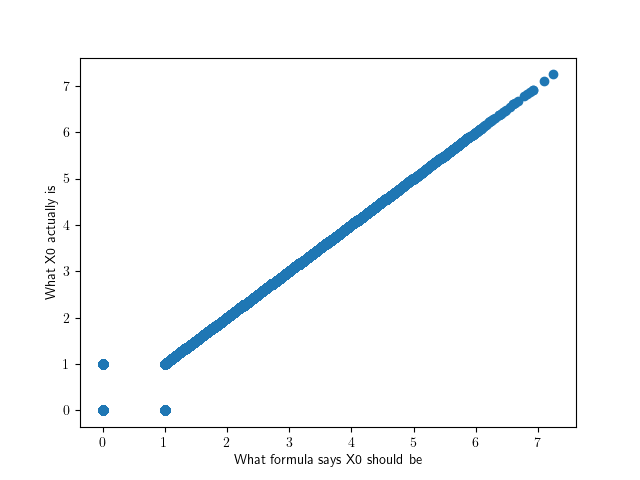

In [11]:
plt.scatter(np.where(X1sum>1,X1sum,0),X0)
plt.xlabel("What formula says X0 should be")
plt.ylabel("What X0 actually is")

In [50]:
np.sum(np.dot(X1sum>=1, X0==0)) + np.dot((X1sum<1 * X0>=1))

1

In [58]:
X1sum[(X1sum>1) & (X0==0)]

array([1.00012207, 1.00012207, 1.00012207, 1.00024414, 1.00012207,
       1.00012207, 1.00012207, 1.00012207, 1.00012207, 1.00012207,
       1.00012207, 1.00012207, 1.00024414, 1.00012207, 1.00012207,
       1.00024414, 1.00012207, 1.00012207, 1.00012207, 1.00012207,
       1.00018311, 1.00024414, 1.00006104, 1.00012207, 1.00012207,
       1.00024414, 1.00012207, 1.00024414, 1.00024414, 1.00024414,
       1.00024414, 1.00012207, 1.00012207, 1.00012207, 1.00024414,
       1.00006104, 1.00012207, 1.00012207, 1.00012207, 1.00012207,
       1.00012207, 1.00012207, 1.00012207, 1.00012207, 1.00012207,
       1.00018311, 1.00024414, 1.00012207, 1.00024414, 1.00024414,
       1.00024414, 1.00024414, 1.00024414, 1.00006104, 1.00024414,
       1.00024414, 1.00024414, 1.00006104, 1.00024414, 1.00012207,
       1.00024414, 1.00012207, 1.00012207, 1.00012207, 1.00024414,
       1.00012207, 1.00012207, 1.00012207, 1.00024414, 1.00012207,
       1.00012207, 1.00024414, 1.00012207, 1.00012207, 1.00024

In [59]:
X1sum[(X1sum<1) & (X0>=1)]

array([0.99987793, 0.99975586, 0.99987793, 0.99975586, 0.99975586,
       0.99993896, 0.99975586, 0.99975586, 0.99987793, 0.99987793,
       0.99987793, 0.99975586, 0.99975586, 0.99987793, 0.99987793,
       0.99987793, 0.99987793, 0.99987793, 0.99987793, 0.99993896,
       0.99975586, 0.99975586, 0.99987793, 0.99975586, 0.99975586,
       0.99975586, 0.99993896, 0.99987793, 0.99987793, 0.99987793,
       0.99987793, 0.99993896, 0.99987793, 0.99975586, 0.99975586,
       0.99987793, 0.99975586, 0.99987793, 0.99987793, 0.99975586,
       0.99987793, 0.99987793, 0.99993896, 0.99993896, 0.99975586,
       0.99993896, 0.99987793, 0.99987793, 0.99987793, 0.99975586,
       0.99987793, 0.99975586, 0.99975586, 0.99993896, 0.99975586,
       0.99987793, 0.99987793, 0.99975586, 0.99987793, 0.99975586,
       0.99987793, 0.99987793, 0.99987793, 0.99987793, 0.99975586,
       0.99987793, 0.99987793, 0.99987793, 0.99987793, 0.99987793,
       0.99993896, 0.99993896, 0.99993896, 0.99987793, 0.99987